In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3)

20

Derivative of a function with a single input

In [4]:
xs = np.arange(-5, 5, 0.5)
xs

array([-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
        0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5])

In [5]:
ys = f(xs)
ys

array([100.  ,  83.75,  69.  ,  55.75,  44.  ,  33.75,  25.  ,  17.75,
        12.  ,   7.75,   5.  ,   3.75,   4.  ,   5.75,   9.  ,  13.75,
        20.  ,  27.75,  37.  ,  47.75])

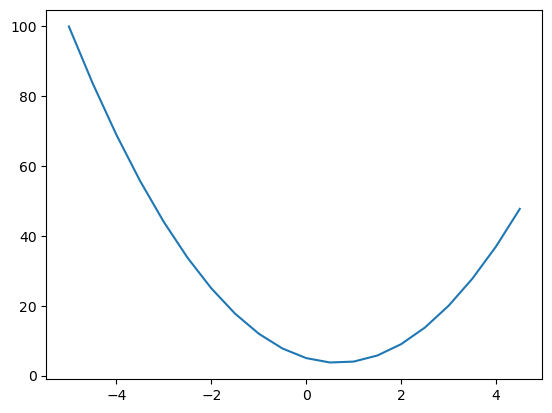

In [6]:
plt.plot(xs, ys)
plt.show()

Derivative: the rate of change of a function wrt change in a variable

m = lim(h->0) (f(x+h)-f(x))/h

In [7]:
x = 3
h = 0.000001

f(x), f(x+h)

(20, 20.000014000003002)

In [8]:
m = (f(x+h)-f(x))/h
m

14.000003002223593

14 is the slope/derivative at x=3
Same concept applied for multi variable complex equations

## Defining a Node

In [9]:
class Value:
    def __init__(self, data):
        self.data = data

    def __repr__(self):
        # used to make custom representations
        return f"Value(data={self.data})"

    def __add__(self, other):
        # defined + operator for Value objects
        # Given: a = Value(x), b = Value(y)
        # Then: a+b = a.__add__(b)
        # self=a, other=b
        return Value(self.data + other.data)

In [10]:
a = Value(3.0)
a

Value(data=3.0)

In [11]:
b = Value(-2)
b

Value(data=-2)

In [12]:
c = a+b
c

Value(data=1.0)

In [13]:
e = Value("hello")
e

Value(data=hello)

In [14]:
f = a+4
f

AttributeError: 'int' object has no attribute 'data'

This class Value takes all types of input, let's limit it to numerics

In [ ]:
class Value:
    def __init__(self, data):
        if not isinstance(data, (int, float)):
            raise TypeError(f"Value only accepts numeric types (int or float), got {type(data).__name__}")
        self.data = data

    def __repr__(self):
        # used to make custom representations
        return f"Value(data={self.data})"

    def __add__(self, other):
        # define + operator for Value objects
        # Given: a = Value(x), b = Value(y)
        # Then: a+b = a.__add__(b)
        # self=a, other=b

        # To make sure value objects can only be added with other value objects
        if not isinstance(other, Value):
            raise TypeError(f"Both operands should be of type: Value, got {type(other).__name__} instead")
        return Value(self.data + other.data)

In [ ]:
a = Value(2.0)
a

In [ ]:
b = Value(-3.0)
b

In [ ]:
c = a+b
c

In [ ]:
d = a+3

In [ ]:
e = Value("h")

## Starting the core values of micrograd

Keep a track of children of each Value

In [15]:
class Value:
    def __init__(self, data, label='', _prev=(), _op=''):
        if not isinstance(data, (int, float)):
            raise TypeError(f"Value only accepts numeric types (int or float), got {type(data).__name__}")
        self.data = data * 1.0  # Ensure it's float for consistency
        self._prev = set(_prev)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _prev=(self, other), _op='+')
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, _prev=(self, other), _op='*')
        
        return out

In [16]:
a = Value(2.0, 'a')
a

Value(data=2.0)

In [17]:
b = Value(-3, 'b')
b

Value(data=-3.0)

In [18]:
c = a+b; c.label='c'
c

Value(data=-1.0)

In [19]:
c._prev

{Value(data=-3.0), Value(data=2.0)}

In [20]:
c._op

'+'

In [21]:
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [22]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [23]:
a = Value(2, 'a')
b = Value(-3, 'b')
c = a*b; c.label='c'
e = Value(10, 'e')
d = c+e; e.label='e'
f = Value(-2, 'f')
L = d*f; L.label='L'

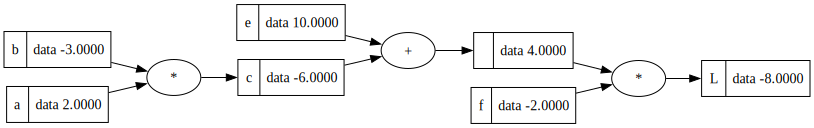

In [24]:
draw_dot(L)

### Add grad to objects:
- gradient of the output wrt that variable
- initially set to 0, assumed that the variable does not affect the output in any way
- a.grad = dL/da

In [25]:
class Value:
    def __init__(self, data, label='', _prev=(), _op=''):
        if not isinstance(data, (int, float)):
            raise TypeError(f"Value only accepts numeric types (int or float), got {type(data).__name__}")
        self.data = data * 1.0
        self.grad = 0.0
        self._prev = set(_prev)
        self._op = _op
        self.label = label
        self._backward = lambda: None # By default set backward to None

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _prev=(self, other), _op='+')

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, _prev=(self, other), _op='*')

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        
        return out

    def prev(self):
        out = []
        for p in self._prev:
            p1 = {
                "Data": p.data,
                "Label": p.label
            }
            out.add(p1)
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, _prev=(self, ), _op='tanh')

        def _backward():
            self.grad = (1.0 - t**2) * out.grad
        out._backward = _backward
        
        return out

In [26]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [27]:
a = Value(2, 'a')
b = Value(-3, 'b')
c = a*b; c.label='c'
e = Value(10, 'e')
d = c+e; d.label='d'
f = Value(-2, 'f')
L = d*f; L.label='L'

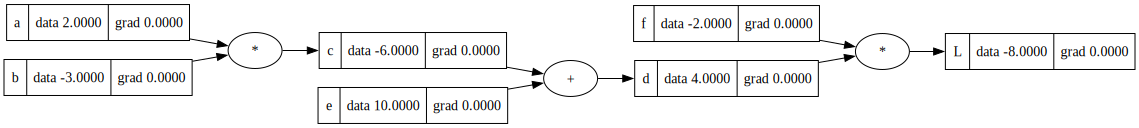

In [28]:
draw_dot(L)

## Manual Backpropogation Example: solving for gradients

- dL/dL = 1

- dL/dd = d(d*f)/dd = f * dd/dd = f = -2
- Similarly dL/df = d = 4

- dL/dc = d(d*f)/dc = d((c+e)*f)/dc = f * d(c+e)/dc = f = -2
  - Or: using chain rule = dL/dc = dL/dd * dd/dc = -2 * d(c+e)/dc = -2*1 = -2
  - Similary: dL/de = -2

In [29]:
L.grad = 1
d.grad = -2
f.grad = 4
c.grad = e.grad = -2

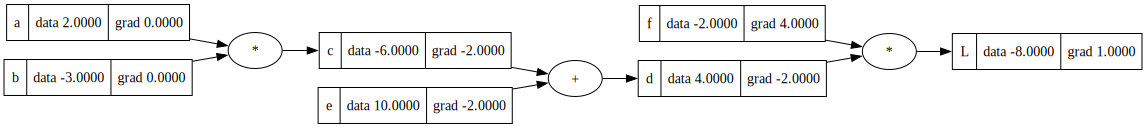

In [30]:
draw_dot(L)

dL/da 
= dL/dd * dd/dc * dc/da
= -2 * 1 * d(a*b)/da
= -2 * b * da/da = -2 * b = -2 * -3 = 6

dL/db = dL/dc * dc/db = -2 * a = -2 * 2 = -4

In [31]:
a.grad = 6
b.grad = -4

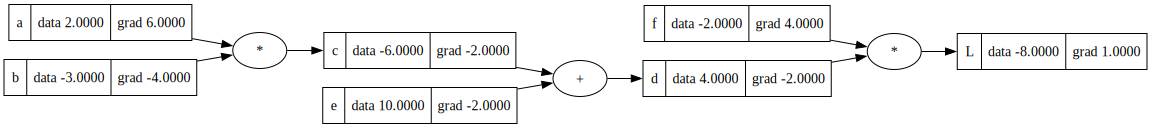

In [32]:
draw_dot(L)

So now, to influence the final outcome (L)

If we want to increase it, we push all/some the independant variables in the direction of their gradients
If we want to decrease outcome, we push all/some the independant variables opposite to the direction of their gradients

In [33]:
# to increase

a.data += 0.001*a.grad
b.data += 0.001*b.grad
e.data += 0.001*e.grad
f.data += 0.001*f.grad

c = a*b
d = c+e
L = d*f
L

Value(data=-7.928064095999999)

L has increased by a small amount

In [34]:
# to increase

a.data += 0.01*a.grad
b.data += 0.01*b.grad
e.data += 0.01*e.grad
f.data += 0.01*f.grad

c = a*b
d = c+e
L = d*f
L

Value(data=-7.215871776)

L has increased more

Now, let's go against the gradient

In [35]:
# to increase

a.data -= 0.02*a.grad
b.data -= 0.02*b.grad
e.data -= 0.02*e.grad
f.data -= 0.02*f.grad

c = a*b
d = c+e
L = d*f
L

Value(data=-8.653114016)

This way, we can optimize the output of our Neural Nets by changing the gradients (weights in NN) using backpropogation

In Neural Nets we try to reduce L (Loss Function) by varying the weights and bias at each node.
Adjust the weights slightly in the opposite direction of the gradient (using gradient descent) to make the error smaller next time.

## Manual Backpropogation Example 2: a Neuron

![Neuron with activation function](./imgs/Neuron2.png)

In [36]:
# Inputs x1, x2
x1 = Value(2, 'x1')
x2 = Value(0, 'x2')

# Weights
w1 = Value(-2, 'w1')
w2 = Value(1, 'w2')

# Bias of the Neuron
b1 = Value(4.7, 'b1')

# Products
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
sum_xw = x1w1+x2w2; sum_xw.label = 'x1w1 + x2w2'
n = sum_xw + b1; n.label='n'

# output
o = n.tanh(); o.label='o'

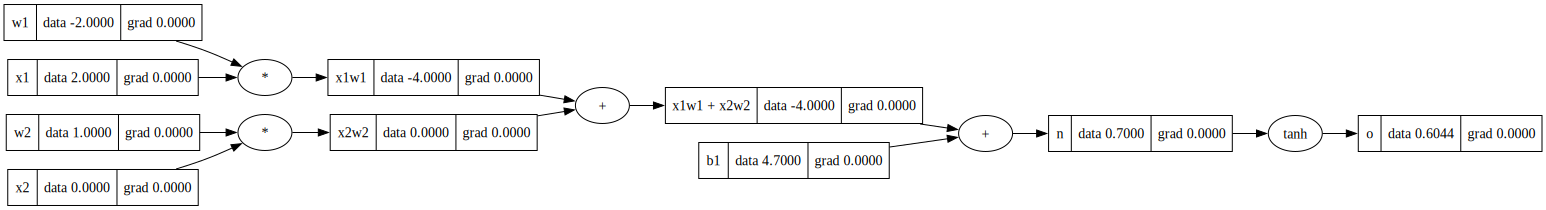

In [37]:
draw_dot(o)

In [38]:
o.grad = 1

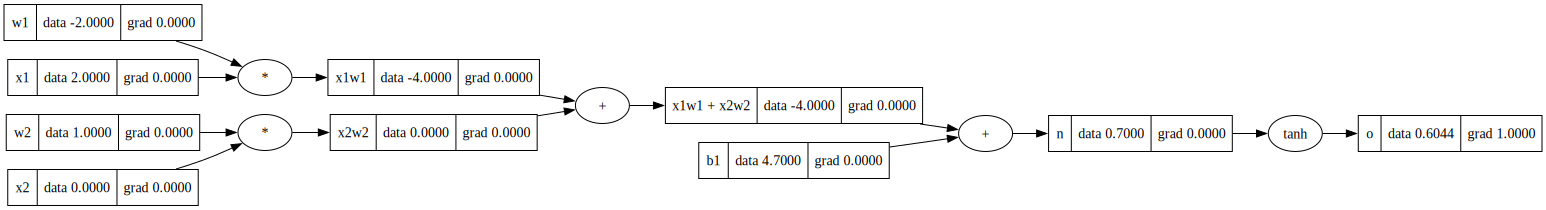

In [39]:
draw_dot(o)

o = tanh(n) = (e\**2n - 1)/(e\**2n + 1)

do/dn 
= (1 - tanh(n)\**2)
= 1 - o\**2
= 1 - 0.6044**2

In [40]:
n.grad = 1-(o.data**2)

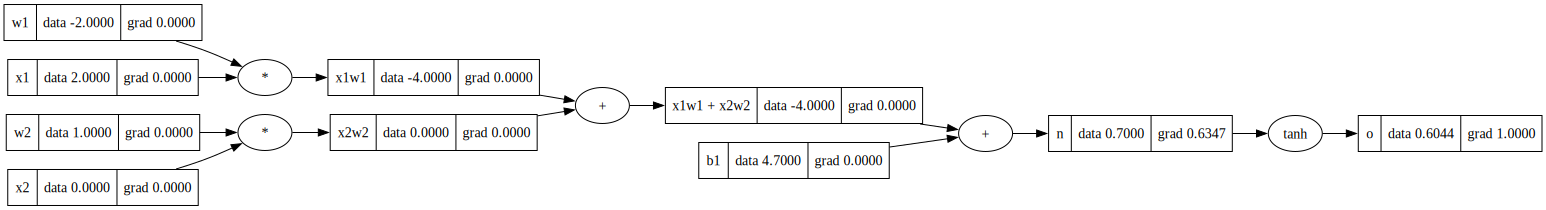

In [41]:
draw_dot(o)

In [42]:
# Since the previous 2 nodes are added, + is just a distributor of gradients
# The gradient will just flow through the nodes

# Eg: do/db1 = do/dn * dn/db1 = (1-o.data**2) * d(sum_xw + b1)/db1 = 1-o.data**2 = n.grad

In [43]:
b1.grad = sum_xw.grad = n.grad

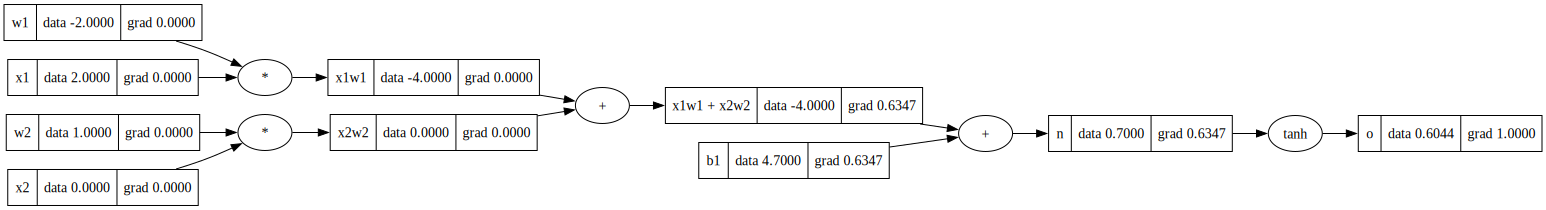

In [44]:
draw_dot(o)

In [45]:
x1w1.grad = x2w2.grad = sum_xw.grad

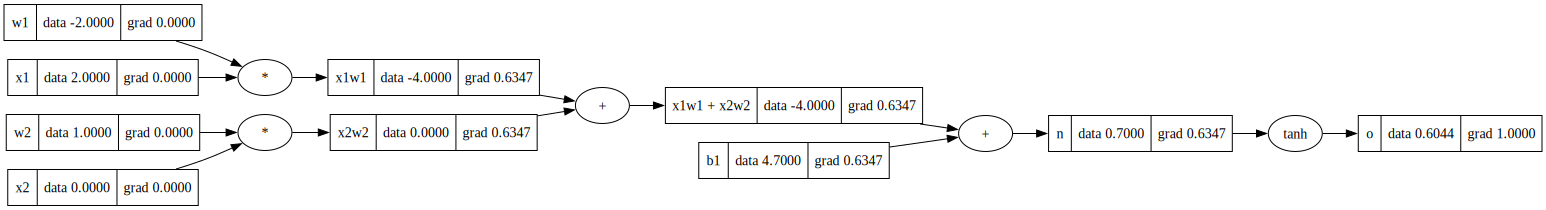

In [46]:
draw_dot(o)

do/dx2 = do/dx2w2 * dx2w2/dx2 = x2w2.grad * w2

In [47]:
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

x1.grad = x1w1.grad * w1.data
w1.grad = x2w2.grad * x1.data

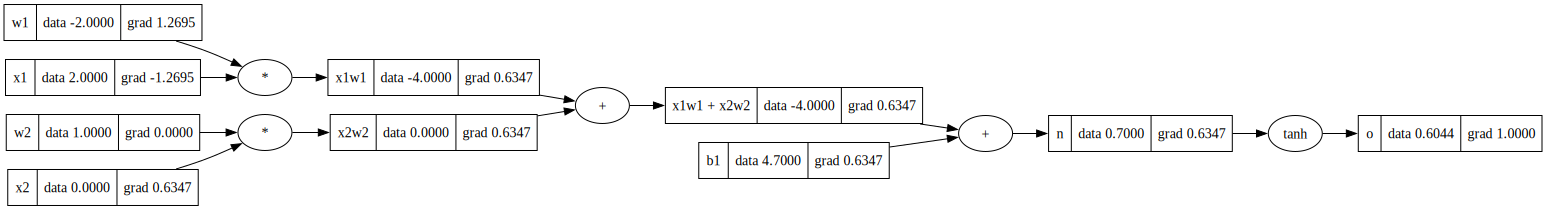

In [48]:
draw_dot(o)

We understand now that,
- w2 does not have any effect on o, as x2 is 0. Therefore x2w2 will always be 0
- w1 positively affects o, increase in w1, will increase o
- b1 has a positive relation as well
- x1, x2 are inputs: So no scope of changing them

## Testing the backpropogation: _backward function

In [49]:
# Inputs x1, x2
x1 = Value(2, 'x1')
x2 = Value(0, 'x2')

# Weights
w1 = Value(-2, 'w1')
w2 = Value(1, 'w2')

# Bias of the Neuron
b1 = Value(4.7, 'b1')

# Products
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
sum_xw = x1w1+x2w2; sum_xw.label = 'x1w1 + x2w2'
n = sum_xw + b1; n.label='n'

# output
o = n.tanh(); o.label='o'

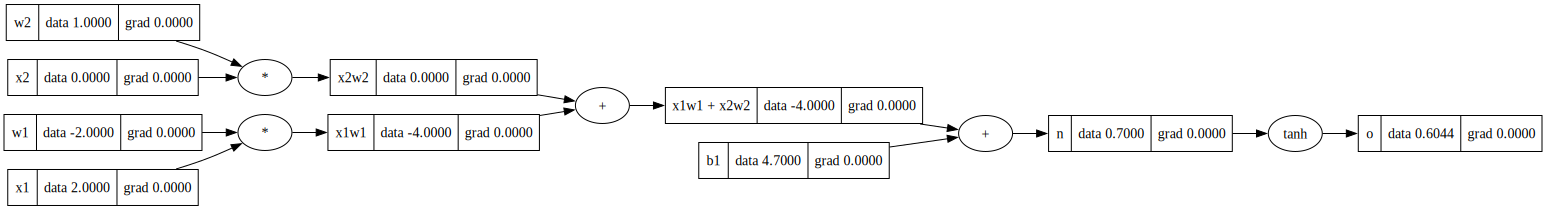

In [50]:
draw_dot(o)

In [51]:
# Initialize
o.grad = 1

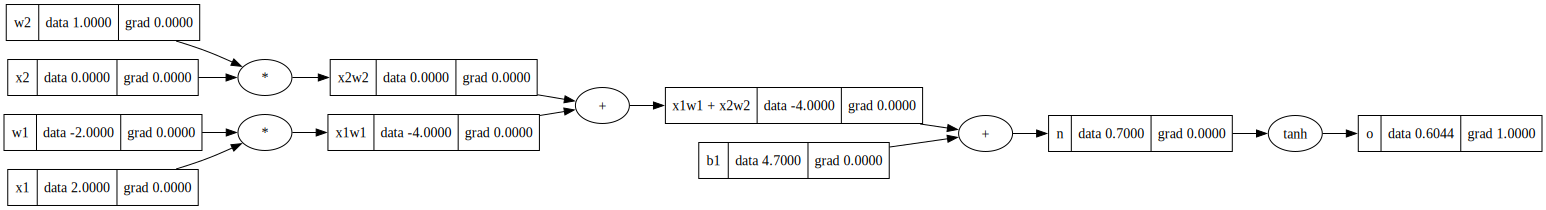

In [52]:
draw_dot(o)

In [53]:
# When we created an object of Value, eg: o, it used the tanh method, 
# so through that path, it has stored a specific _backward function, the one we defined for _backward inside the tanh method

o._backward()

In [54]:
n._prev

{Value(data=-4.0), Value(data=4.7)}

In [55]:
n._backward()

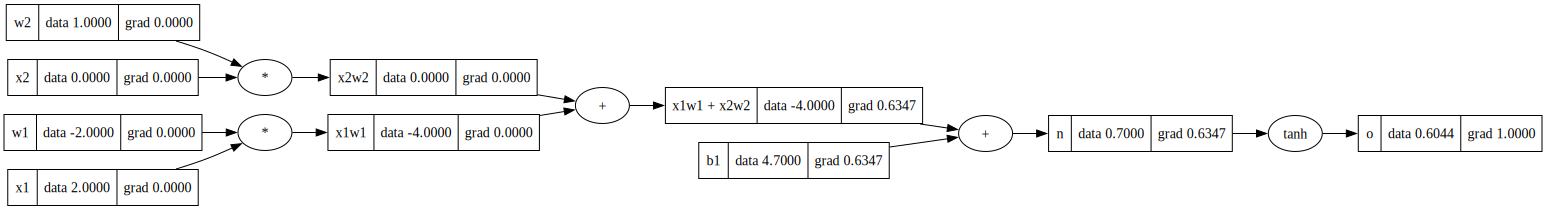

In [56]:
draw_dot(o)

In [57]:
sum_xw._backward()

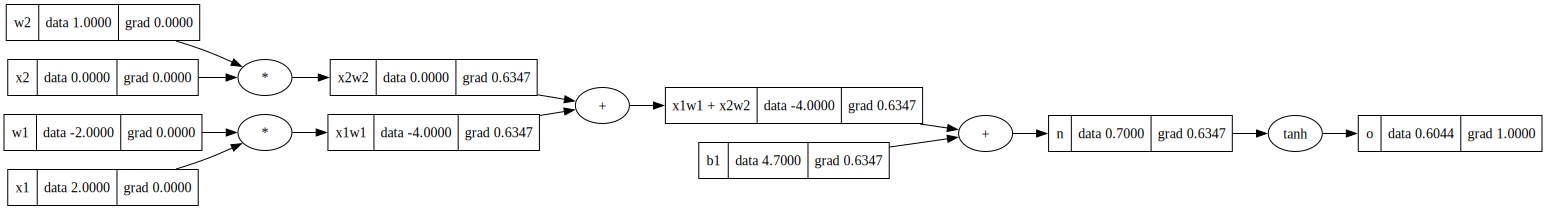

In [58]:
draw_dot(o)

In [59]:
x1w1._backward()
x2w2._backward()

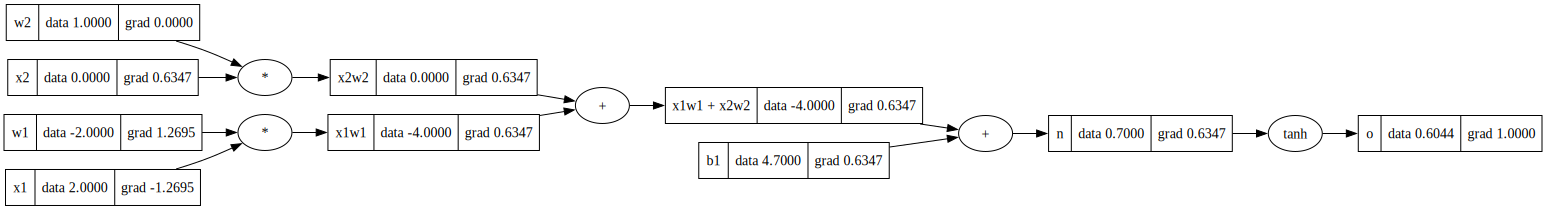

In [60]:
draw_dot(o)

### Now, let's try to use recursion to prevent calculating backward for each node

In [61]:
class Value:
    def __init__(self, data, label='', _prev=(), _op=''):
        if not isinstance(data, (int, float)):
            raise TypeError(f"Value only accepts numeric types (int or float), got {type(data).__name__}")
        self.data = data * 1.0
        self.grad = 0.0
        self._prev = set(_prev)
        self._op = _op
        self.label = label
        self._backward = lambda: None # By default set backward to None

    def __repr__(self):
        return f"Value({self.label}={self.data}, grad={self.grad})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _prev=(self, other), _op='+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, _prev=(self, other), _op='*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def prev(self):
        out = [self._op]
        for p in self._prev:
            p1 = {
                "Data": p.data,
                "Label": p.label
            }
            out.append(p1)
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), _prev=(self, ), _op='exp')

        def _backward():
            self.grad += out.data * out.grad()
        out._backward = _backward
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, _prev=(self, ), _op='tanh')

        def _backward():
            self.grad += (1.0 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):       
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

In [62]:
# Inputs x1, x2
x1 = Value(2, 'x1')
x2 = Value(0, 'x2')

# Weights
w1 = Value(-2, 'w1')
w2 = Value(1, 'w2')

# Bias of the Neuron
b1 = Value(4.7, 'b1')

# Products
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
sum_xw = x1w1+x2w2; sum_xw.label = 'x1w1 + x2w2'
n = sum_xw + b1; n.label='n'

# output
o = n.tanh(); o.label='o'

In [63]:
o

Value(o=0.6043677771171636, grad=0.0)

In [64]:
n._prev

{Value(b1=4.7, grad=0.0), Value(x1w1 + x2w2=-4.0, grad=0.0)}

In [65]:
n.prev()

['+', {'Data': -4.0, 'Label': 'x1w1 + x2w2'}, {'Data': 4.7, 'Label': 'b1'}]

To automate the _backward function for all the nodes
We need to create a flow, left->right
Where all the child (source) nodes are entered before appending the node itself

Eg: a, b, c=a+b, d=c*b
so if we call topo(d)
\[a,b,c,d] should be the order: So we can run _backward from right->left

In [66]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(w2=1.0, grad=0.0),
 Value(x2=0.0, grad=0.0),
 Value(x2w2=0.0, grad=0.0),
 Value(x1=2.0, grad=0.0),
 Value(w1=-2.0, grad=0.0),
 Value(x1w1=-4.0, grad=0.0),
 Value(x1w1 + x2w2=-4.0, grad=0.0),
 Value(b1=4.7, grad=0.0),
 Value(n=0.7000000000000002, grad=0.0),
 Value(o=0.6043677771171636, grad=0.0)]

In [67]:
sum_xw._prev

{Value(x1w1=-4.0, grad=0.0), Value(x2w2=0.0, grad=0.0)}

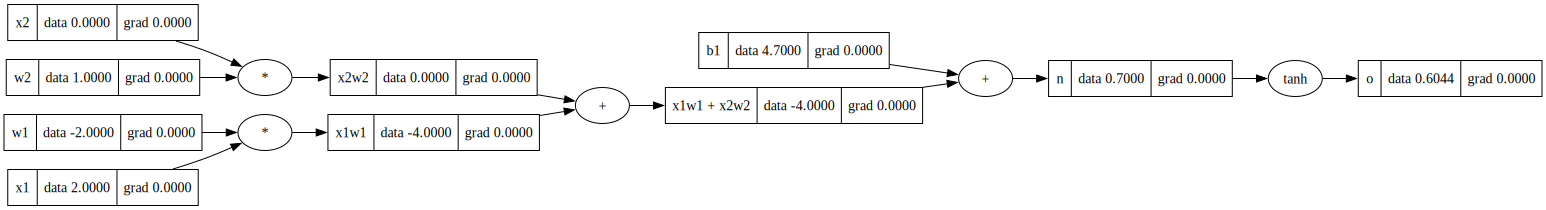

In [68]:
draw_dot(o)

In [69]:
o.backward()

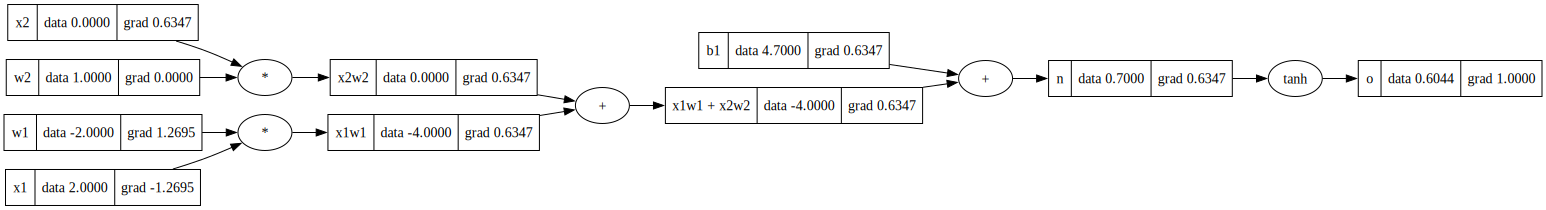

In [70]:
draw_dot(o)

### This was backpropogation: Calculating the gradient of the final output wrt each node

#### Now we have a silent bug, our current model will give errors if the same node is used multiple times

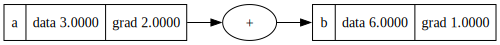

In [71]:
a = Value(3, 'a')
b = a+a; b.label='b'
b.backward()
draw_dot(b)

Here we should have a.grad=2, as db/da=2.
But we receive 1, 

In [72]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(b)
topo

[Value(a=3.0, grad=2.0), Value(b=6.0, grad=1.0)]

In [73]:
b._prev

{Value(a=3.0, grad=2.0)}

In [74]:
a = Value(-2, 'a')
b = Value(3, 'b')
d = a*b; d.label='d'
e = a+b; e.label='e'
f = d*e; f.label='f'

In [75]:
f.backward()

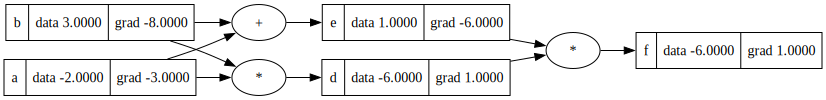

In [76]:
draw_dot(f)

Incase of repeated uses, the gradients will be accumulated.
Eg: a.grad += grad

In [77]:
a = Value(3)
2 + a

Value(=5.0, grad=0.0)

#### This same backprop can be done using pytorch, in a more efficient way as it uses tensors

## Building a Neural Net Library

### Building a Neuron

In [78]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)] #Weights array, for the Neuron, same as number of inputs
        self.b = Value(random.uniform(-1, 1)) # Bias, single value for each Neuron

    def __call__(self, x):
        # y = sum(wx) + b
        tup = zip(self.w, x)
        
        act = sum(wi*xi for wi,xi in tup) + self.b
        out = act.tanh()
        return out

x = [2, 3]
n = Neuron(2)
n(x)

Value(=-0.6230042368840423, grad=0.0)

In [79]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs

![Neural Network](./imgs/NeuralNet.png)

In [80]:
x = [1, 2, -3, 5, 6]
l = Layer(5, 6)
l(x)

[Value(=0.9840105408858345, grad=0.0),
 Value(=0.8083924048633062, grad=0.0),
 Value(=-0.9967335122624531, grad=0.0),
 Value(=0.9996908357901421, grad=0.0),
 Value(=0.671745861044381, grad=0.0),
 Value(=-0.1924502758351015, grad=0.0)]